In [1]:
# uncomment the code below to install all dependencies
#!pip install tensorboard==2.13.0 \
#     tensorflow==2.13.0 \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     tqdm==4.65.0 \
#     scipy==1.11.1 \
#     scikit-learn==1.3.0 \
#     numpy==1.24.3 \
#     Pillow==10.0.0

In [1]:
import os
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm

from typing import List, Any

import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing import normalize

from PIL import Image
import requests
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorboard.plugins import projector

movies_df = pl.from_pandas(pd.read_parquet('imdb_movies.parquet'))
movies_df

title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
str,str,str,str,str,str,list[str],str,f64,f64,list[str],str,list[str],list[str],list[str]
"""tt0111161""","""https://m.medi…","""Movie""","""Побег из Шоуше…","""The Shawshank …","""Over the cours…","[""Drama""]","""1994-10-14""",2.755277e6,9.3,"[""prison"", ""based on the works of stephen king"", … ""voice over narration""]","""It is no wonde…","[""Tim Robbins"", ""Morgan Freeman"", ""Bob Gunton""]","[""Frank Darabont""]","[""Stephen King"", ""Frank Darabont""]"
"""tt0068646""","""https://m.medi…","""Movie""","""Крестный отец""","""The Godfather""","""Don Vito Corle…","[""Crime"", ""Drama""]","""1972-03-24""",1.917037e6,9.2,"[""mafia"", ""patriarch"", … ""rise to power""]","""I love this mo…","[""Marlon Brando"", ""Al Pacino"", ""James Caan""]","[""Francis Ford Coppola""]","[""Mario Puzo"", ""Francis Ford Coppola""]"
"""tt0468569""","""https://m.medi…","""Movie""","""Тёмный рыцарь""","""The Dark Knigh…","""When the menac…","[""Action"", ""Crime"", ""Drama""]","""2008-08-14""",2.728169e6,9.0,"[""dc comics"", ""psychopath"", … ""clown""]","""If someone els…","[""Christian Bale"", ""Heath Ledger"", ""Aaron Eckhart""]","[""Christopher Nolan""]","[""Jonathan Nolan"", ""Christopher Nolan"", ""David S. Goyer""]"
"""tt0050083""","""https://m.medi…","""Movie""","""12 разгневанны…","""12 Angry Men""","""The jury in a …","[""Crime"", ""Drama""]","""1961-11-13""",816234.0,9.0,"[""jury"", ""dialogue driven"", … ""jury room""]","""&apos;12 Angry…","[""Henry Fonda"", ""Lee J. Cobb"", ""Martin Balsam""]","[""Sidney Lumet""]","[""Reginald Rose""]"
"""tt0071562""","""https://m.medi…","""Movie""","""Крестный отец …","""The Godfather …","""The early life…","[""Crime"", ""Drama""]","""1974-12-18""",1.305122e6,9.0,"[""revenge"", ""1950s"", … ""lake tahoe nevada""]","""The original G…","[""Al Pacino"", ""Robert De Niro"", ""Robert Duvall""]","[""Francis Ford Coppola""]","[""Francis Ford Coppola"", ""Mario Puzo""]"
"""tt0108052""","""https://m.medi…","""Movie""","""Список Шиндлер…","""Schindler&apos…","""In German-occu…","[""Biography"", ""Drama"", ""History""]","""1994-05-21""",1.388917e6,9.0,"[""holocaust"", ""nazi"", … ""german""]","""This Movie was…","[""Liam Neeson"", ""Ralph Fiennes"", ""Ben Kingsley""]","[""Steven Spielberg""]","[""Thomas Keneally"", ""Steven Zaillian""]"
"""tt0167260""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""Gandalf and Ar…","[""Action"", ""Adventure"", ""Drama""]","""2004-01-22""",1.892435e6,9.0,"[""journey"", ""orc"", … ""ring""]","""Wonderful on e…","[""Elijah Wood"", ""Viggo Mortensen"", ""Ian McKellen""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"
"""tt0110912""","""https://m.medi…","""Movie""","""Криминальное ч…","""Pulp Fiction""","""The lives of t…","[""Crime"", ""Drama""]","""1995-09-29""",2.115956e6,8.9,"[""nonlinear timeline"", ""overdose"", … ""drug dealing""]","""I can only spe…","[""John Travolta"", ""Uma Thurman"", ""Samuel L. Jackson""]","[""Quentin Tarantino""]","[""Quentin Tarantino"", ""Roger Avary""]"
"""tt0120737""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""A meek Hobbit …","[""Action"", ""Adventure"", ""Drama""]","""2002-03-01""",1.920951e6,8.8,"[""ring"", ""quest"", … ""elf""]","""Here is one fi…","[""Elijah Wood"", ""Ian McKellen"", ""Orlando Bloom""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"


## Data Description

For solving the task, the following data from the `imdb_movies.parquet` file are available:

| Field           | Type                | Description                                             |
|-----------------|---------------------|---------------------------------------------------------|
| title_id        | str                 | IMDb identifier                                         |
| poster_url      | str                 | Link to the poster                                      |
| type            | str                 | Type of the title: Movie or TVSeries                    |
| name            | str                 | Title name in Russian                                   |
| original_name   | str                 | Original title name                                     |
| description     | str                 | Title description from IMDb                             |
| genre           | list[str]           | List of genres                                          |
| date            | str                 | Release date of the title                               |
| rating_count    | int                 | Number of reviews for the title                         |
| rating_value    | float               | Average rating of the title                             |
| keywords        | list[str]           | Keywords for the title (generated by IMDb users)        |
| featured_review | str                 | Featured review for the title                           |
| stars           | list[str]           | List of key actors                                      |
| directors       | list[str]           | List of directors                                       |
| creators        | list[str]           | List of creators                                        |


## Evaluation

The quality metric used is hitrate@10, which can be interpreted as **the probability that at least one of the top-10 recommended items is relevant**. 
As `y_relevant`, titles that occur together in user ratings are used.

In [19]:
TOP_K = 10
SUBMISSION_PATH = 'submission.parquet'
RELEVANT_TITLES_PATH = 'relevant_titles_subsample.parquet'


#def hitrate(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> int:
#    return int(len(set(y_relevant).intersection(y_preds[:k])) > 0)

def user_hitrate(y_rel: List[Any], y_rec: List[Any], k: int = 10) -> int:
    """
    :param y_rel: relevant items
    :param y_rec: recommended items
    :param k: number of top recommended items
    :return: 1 if top-k recommendations contains at lease one relevant item
    """
    return int(len(set(y_rec[:k]).intersection(set(y_rel))) > 0)

# код для подсчета метрики качества 1
def print_score(SUBMISSION_PATH):
    hitrate_list = []
    user_preds = {title_id: recs for title_id, recs in pl.read_parquet(SUBMISSION_PATH).rows()}
    for title_id, relevant_items in pl.read_parquet(RELEVANT_TITLES_PATH).rows():
        recommended_titles = user_preds.get(title_id, [])[:TOP_K]
        hitrate_list.append(user_hitrate(relevant_items, recommended_titles))

    mean_hitrate = float(np.mean(hitrate_list))
    print(f'HITRATE@10 = {mean_hitrate}')



## Random recommendations

In [4]:
def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    # берем с запасом, чтобы не рекомендовать тайтл для самого себя
    random_movies = np.random.choice(movies_df['title_id'].unique().to_list(), TOP_K + 1)
    return [title_id for title_id in random_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission_random.parquet')

print_score('submission_random.parquet')

100%|██████████| 9798/9798 [00:45<00:00, 213.27it/s]


HITRATE@10 = 0.04


## Recommendations of the most popular items

In [5]:
# we take with a margin, so as not to recommend a title to itself

top_movies = movies_df.sort('rating_value', descending=True)['title_id'][:(TOP_K + 1)].to_list()

def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    return [title_id for title_id in top_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission_top.parquet')

print_score('submission_top.parquet')

100%|██████████| 9798/9798 [00:00<00:00, 26977.62it/s]


HITRATE@10 = 0.08


## Sparce matrix format

In [6]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
sp.csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

## Let's build recommendations based on the intersection of keywords.

In [7]:
movies_df['keywords'].explode().unique()

keywords
str
"""irish mafia"""
"""assertion"""
"""bloody mess"""
"""under arrest"""
"""90 year old"""
"""direct to vide…"
"""village idiot"""
"""deceased wife"""
"""spider man act…"


In [8]:
mapping = {
    k: v
    for v, k in enumerate(movies_df['keywords'].explode().unique().to_list())
}
print(f'{len(mapping)}')

15052


In [9]:
# gather rows for the sparse matrix

rows = []
cols = []
values = []
for row_ind, keywords in enumerate(movies_df['keywords']):
    col_inds = [mapping[x] for x in keywords]
    rows.extend([row_ind] * len(col_inds))
    values.extend([1] * len(col_inds))
    cols.extend(col_inds)

In [10]:
sparse_data = sp.csr_matrix((values, (rows, cols)))
sparse_data = normalize(sparse_data, norm='l2', axis=1)
display(sparse_data)

similarities = (sparse_data @ sparse_data.T).A
# уберем 1 по диагонали, чтобы не рекомендовать тайтл для самого себя
similarities -= np.eye(len(similarities), dtype=similarities.dtype)
display(similarities.shape)

<9798x15052 sparse matrix of type '<class 'numpy.float64'>'
	with 45762 stored elements in Compressed Sparse Row format>

(9798, 9798)

In [11]:
def get_recommendations(title_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[title_ind])[::-1][:k]
    return movies_df[nearest_inds]['title_id'].to_list()

TOP_K = 10

submission = []
for title_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][title_ind]
    recommended_titles = get_recommendations(title_ind, TOP_K)
    submission.append((title_id, recommended_titles))

submission = pl.DataFrame(submission, schema=('title_id', 'recs'))
submission.write_parquet('submission.parquet')
display(submission.head())

print_score('submission.parquet')

100%|██████████| 9798/9798 [00:06<00:00, 1590.64it/s]


title_id,recs
str,list[str]
"""tt0111161""","[""tt6589464"", ""tt7667038"", … ""tt0072684""]"
"""tt0068646""","[""tt11497716"", ""tt7661390"", … ""tt9820352""]"
"""tt0468569""","[""tt7302054"", ""tt0078346"", … ""tt2193021""]"
"""tt0050083""","[""tt7949212"", ""tt0050051"", … ""tt8975028""]"
"""tt0071562""","[""tt4882708"", ""tt11151696"", … ""tt4264096""]"


HITRATE@10 = 0.101


## Save embeddings for viewing in TensorBoard

In [12]:
!rm -rf ./embs

In [13]:
log_dir = './embs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for title_name in movies_df[:1_000]['name']:
        f.write(f'{title_name}\n')

weights = tf.Variable(sparse_data[:1_000].A)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [18]:
!tensorboard --logdir embs --bind_all

2023-12-03 15:00:37.814036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.13.0 at http://7d1e2360cdc1:6006/ (Press CTRL+C to quit)


## Visualization of recommendations

In [19]:
def get_recommendations_inds(item_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[item_ind])[::-1][:k]
    return nearest_inds

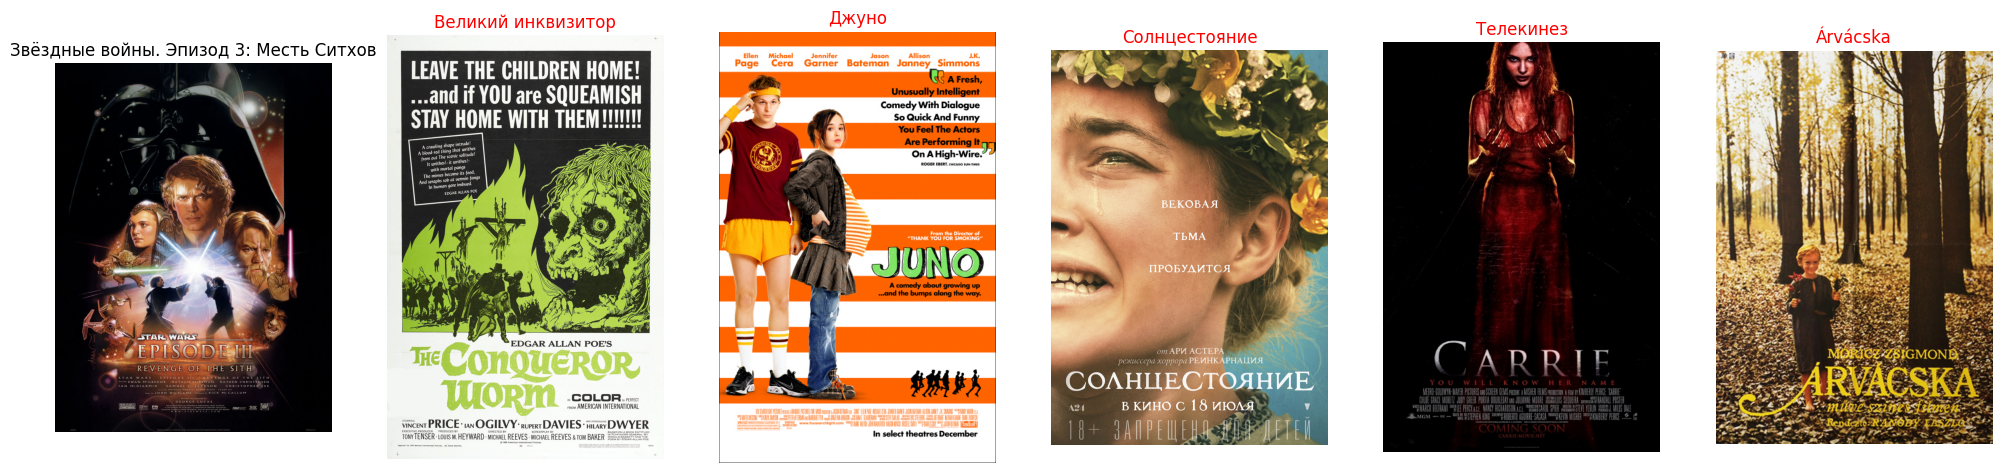

In [21]:
k = 5
fig, axs = plt.subplots(1, k + 1, figsize=(25, 10))

title_id = 'tt0121766'
title_ind = movies_df['title_id'].to_list().index(title_id)

relevant_titles = (
    pl.read_parquet(RELEVANT_TITLES_PATH)
    .filter(pl.col('title_id') == title_id)
)['relevant_titles'].explode().to_list()

# generating title
url = movies_df['poster_url'][title_ind]
im = Image.open(requests.get(url, stream=True).raw)
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title(movies_df['name'][title_ind])

# create recomendations
nearest_inds = get_recommendations_inds(title_ind, k)
recs_posters = movies_df[nearest_inds]['poster_url']
recs_names = movies_df[nearest_inds]['name']
recs_title_ids = movies_df[nearest_inds]['title_id']

# visualize recomendations
for i, (url, name) in enumerate(zip(recs_posters, recs_names)):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[1 + i].imshow(im)
    axs[1 + i].axis('off')
    axs[1 + i].set_title(name, color=('g' if recs_title_ids[i] in relevant_titles else 'r'))

plt.show();

## Build recommendations based on OpenAI embeddings

In [2]:
#!pip install openai
#!pip install tiktoken
#!pip install utils
#!pip install openai[embeddings]

In [2]:
import openai
import tiktoken
from openai import OpenAI

In [3]:
def get_embedding(text: str, model="text-embedding-ada-002", **kwargs) -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = openai.embeddings.create(input=[text], model=model, **kwargs)

    return response.data[0].embedding

In [4]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8191  # the maximum for text-embedding-ada-002 is 8191

In [5]:
df = movies_df[['title_id', 'keywords', 'description', 'genre', 'date']]
import polars as pl

# Assuming df is your Polars DataFrame and it has been loaded already
df = df.drop_nulls()

# Define a function to join list elements into a string
def join_keywords(keywords_list):
    return ", ".join(keywords_list)

# Define a function to join list elements into a string
def join_list_elements(list_items):
    return ", ".join(list_items)

# Apply the function to the 'keywords' and 'genre' columns
df = df.with_columns([
    df['keywords'].apply(join_list_elements).alias("keywords_str"),
    df['genre'].apply(join_list_elements).alias("genre_str")
])

# Now concatenate the string columns
df = df.with_columns([
    (pl.lit("keywords: ") + df['keywords_str'].str.strip() +
     pl.lit("; description: ") + df['description'].str.strip() +
     pl.lit("; genre: ") + df['genre_str'].str.strip() +
     pl.lit("; date: ") + df['date'].str.strip()).alias("combined")
])



df.head(2)


title_id,keywords,description,genre,date,keywords_str,genre_str,combined
str,list[str],str,list[str],str,str,str,str
"""tt0111161""","[""prison"", ""based on the works of stephen king"", … ""voice over narration""]","""Over the cours…","[""Drama""]","""1994-10-14""","""prison, based …","""Drama""","""keywords: pris…"
"""tt0068646""","[""mafia"", ""patriarch"", … ""rise to power""]","""Don Vito Corle…","[""Crime"", ""Drama""]","""1972-03-24""","""mafia, patriar…","""Crime, Drama""","""keywords: mafi…"


In [6]:
encoding = tiktoken.get_encoding(embedding_encoding)

# Define a function to count the number of tokens
def count_tokens(text):
    return len(encoding.encode(text))

# Apply this function to the 'combined' column
df = df.with_columns([
    df['combined'].apply(count_tokens).alias("n_tokens")
])

# Filter rows where the number of tokens is less than or equal to max_tokens
df = df.filter(pl.col("n_tokens") <= max_tokens)

# Getting the length of the dataframe
len_df = len(df)

In [7]:
len(movies_df)

9798

In [8]:
openai.api_key = 'key'
client = OpenAI(api_key='key')

In [9]:
def get_embeddings(texts):
    # Replace 'your_openai_api_key' with your actual OpenAI API key

    # Process the texts in batches if too large
    batch_size = 20  # Adjust the batch size based on your text size and memory constraints
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        response = client.embeddings.create(input=batch_texts,
        model=embedding_model)
        embeddings.extend(response['data'])

    return embeddings

In [10]:
df = df.with_columns([
    df['combined'].apply(lambda x: get_embedding(x)).alias("embedding")
])

In [11]:
df.write_parquet("df_embeddings_1.parquet")

In [12]:
# Generate embeddings
embeddings = df["embedding"]

In [23]:
# Convert the list of embeddings to a 2D NumPy array
embeddings_array = np.vstack(embeddings)

# Create a sparse matrix from the 2D array of embeddings
sparse_data = sp.csr_matrix(embeddings_array)
sparse_data = normalize(sparse_data, norm='l2', axis=1)

# Compute similarities
similarities = (sparse_data @ sparse_data.T).A

# Remove self-similarity
similarities -= np.eye(len(similarities), dtype=similarities.dtype)

In [25]:
# Recommendation function
def get_recommendations(title_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[title_ind])[::-1][:k]
    return movies_df[nearest_inds]['title_id'].to_list()

# Generating recommendations for all movies
TOP_K = 10
submission = []
for title_ind in tqdm(range(len(similarities))):
    title_id = movies_df['title_id'][title_ind]
    recommended_titles = get_recommendations(title_ind, TOP_K)
    submission.append((title_id, recommended_titles))

# Saving recommendations
submission = pl.DataFrame(submission, schema=('title_id', 'recs'))
submission.write_parquet('submission_openai.parquet')
display(submission.head())

# Function to print score - assuming this is defined elsewhere
print_score('submission_openai.parquet')

100%|██████████| 9403/9403 [00:11<00:00, 816.78it/s]


title_id,recs
str,list[str]
"""tt0111161""","[""tt2024544"", ""tt1529572"", … ""tt0051507""]"
"""tt0068646""","[""tt0071562"", ""tt0099685"", … ""tt6589464""]"
"""tt0468569""","[""tt0365748"", ""tt0028757"", … ""tt1600195""]"
"""tt0050083""","[""tt0050825"", ""tt0091225"", … ""tt11727052""]"
"""tt0071562""","[""tt0068646"", ""tt0014429"", … ""tt2933474""]"


HITRATE@10 = 0.133


In [27]:
# Saving the same DataFrame as CSV
import polars as pl

# Example function to convert a list to a comma-separated string
def list_to_string(lst):
    return ', '.join(str(elem) for elem in lst)

# Apply this transformation to the nested column
submission = submission.with_columns(
    submission['recs'].apply(list_to_string).alias('recs')
)

# Now try saving as CSV
submission.write_csv('submission_openai.csv')

In [31]:
import polars as pl
import json

# Function to convert list to a string representation of the list
def list_to_json_string(lst):
    return json.dumps(lst)  # Converts the list to a JSON string

# Apply this transformation to the 'recs' column
submission = submission.with_columns(
    submission['recs'].apply(list_to_json_string).alias('recs')
)

# Now try saving as CSV
submission.write_csv('submission_openai.csv')

## Visualization

In [28]:
def get_recommendations_inds(item_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[item_ind])[::-1][:k]
    return nearest_inds

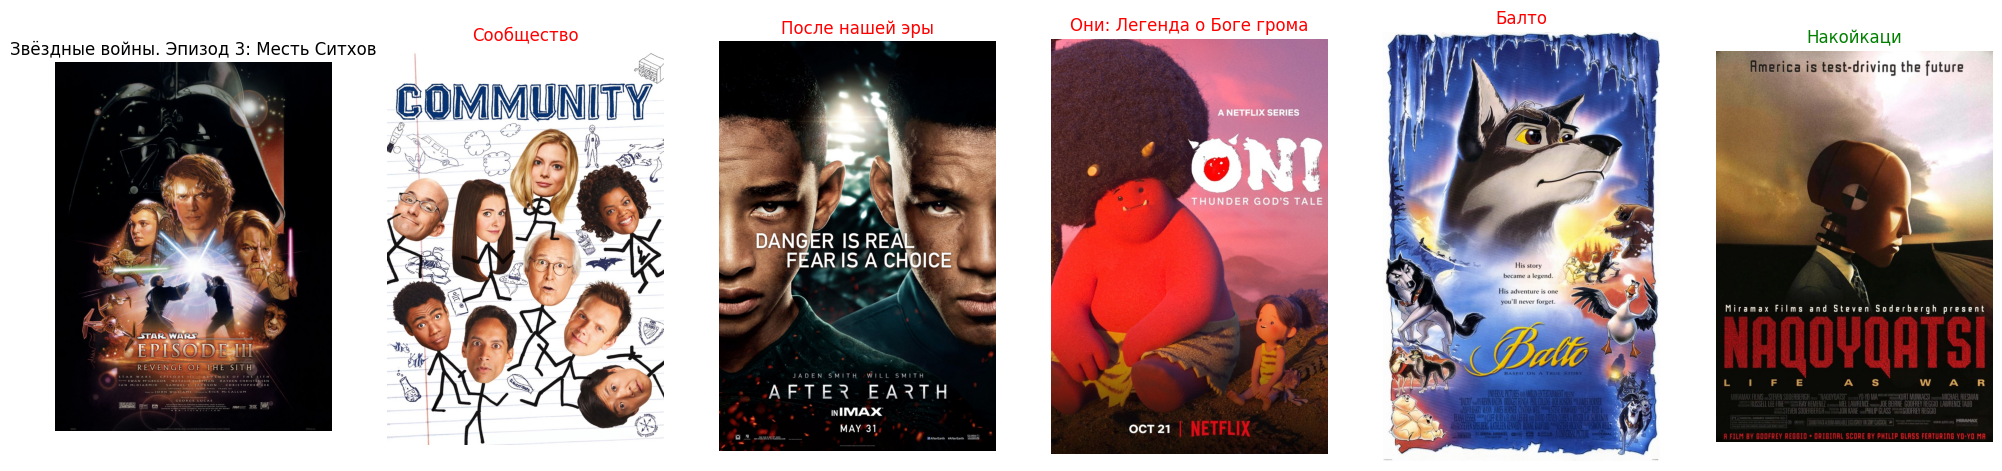

In [29]:
k = 5
fig, axs = plt.subplots(1, k + 1, figsize=(25, 10))

title_id = 'tt0121766'
title_ind = movies_df['title_id'].to_list().index(title_id)

relevant_titles = (
    pl.read_parquet(RELEVANT_TITLES_PATH)
    .filter(pl.col('title_id') == title_id)
)['relevant_titles'].explode().to_list()

# generating title
url = movies_df['poster_url'][title_ind]
im = Image.open(requests.get(url, stream=True).raw)
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title(movies_df['name'][title_ind])

# create recomendations
nearest_inds = get_recommendations_inds(title_ind, k)
recs_posters = movies_df[nearest_inds]['poster_url']
recs_names = movies_df[nearest_inds]['name']
recs_title_ids = movies_df[nearest_inds]['title_id']

# visualize recomendations
for i, (url, name) in enumerate(zip(recs_posters, recs_names)):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[1 + i].imshow(im)
    axs[1 + i].axis('off')
    axs[1 + i].set_title(name, color=('g' if recs_title_ids[i] in relevant_titles else 'r'))

plt.show();

Ideas for further improvement:
- try different metrics for measuring the distance between embeddings
- use more features to build the sparse matrix
- try using the description and featured_review for feature extraction (for example, tf-idf/w2v/OpenAI embeddings)